In [2]:
#!pip install netCDF4
#!pip install basemap
!pip install cartopy

  Using cached Cartopy-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)


In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

import pyproj
import cartopy.crs as ccrs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import regularizers

In [4]:
#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            continue
            #print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            #print("Gaussian SSD curve-fit error: "+str(t))
            continue

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD

In [5]:
import datetime
def find_sections(SAR,OLCI,shape):
  SAR_start = datetime.datetime.strptime(SAR[25:31],"%H%M%S")
  SAR_end = datetime.datetime.strptime(SAR[41:47],"%H%M%S")
  OLCI_start = datetime.datetime.strptime(OLCI[25:31],"%H%M%S")
  OLCI_end = datetime.datetime.strptime(OLCI[41:47],"%H%M%S")
  start = OLCI_start-SAR_start
  end = OLCI_end-SAR_start
  total = SAR_end-SAR_start
  start = start.total_seconds()
  end = end.total_seconds()
  total = total.total_seconds()
  where_start = int(start/total * shape // 300)
  where_end = int(end/total * shape // 300)
  return where_start,where_end

In [6]:
fileSAR = 'S3A_SR_2_LAN_SI_20180607T072307_20180607T073813_20230507T001656_0906_032_092______LN3_R_NT_005'
fileOLCI = 'S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002'
print(fileSAR[25:31])
print(fileSAR[41:47])
print(fileOLCI[25:31])
#print(find_sections(fileSAR,fileOLCI,waves.shape[0]))
#print(waves.shape)
#match_list = np.load(path+'match_list.npy',allow_pickle=True)[:]
#print(match_list[:,0])

072307
073813
073416


In [7]:
#MOUNT DATA
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

path = '/content/drive/MyDrive/Colab_Notebooks/Project/'
pathOLCI = '/content/drive/MyDrive/Colab_Notebooks/Project/OLCI/'
pathSAR = '/content/drive/MyDrive/Colab_Notebooks/Project/SAR_analysis/'
pathS2 = '/content/drive/MyDrive/Colab_Notebooks/Project/S2_Analysis/OLCI_data/'
file = 'S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002/S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002.SEN3'

Mounted at /content/drive


In [8]:
match_list = np.load(path+'match_list.npy',allow_pickle=True)[:]

selects = match_list[:,0]
matching_SAR_list = match_list[:,1]
print(match_list[:,:])

[[None None]
 ['S3A_OL_1_EFR____20180607T004419_20180607T004719_20180608T044543_0179_032_088_1260_LN1_O_NT_002'
  'S3A_SR_2_LAN_SI_20180607T003545_20180607T010236_20230507T042611_1611_032_088______LN3_R_NT_005.SEN3']
 ['S3B_OL_1_EFR____20180607T004358_20180607T004658_20200126T022532_0179_009_088_1260_MR1_R_NT_002'
  'S3A_SR_2_LAN_SI_20180607T003545_20180607T010236_20230507T042611_1611_032_088______LN3_R_NT_005.SEN3']
 ['S3A_OL_1_EFR____20180607T005319_20180607T005619_20180608T044647_0179_032_088_1800_LN1_O_NT_002'
  'S3A_SR_2_LAN_SI_20180607T003545_20180607T010236_20230507T042611_1611_032_088______LN3_R_NT_005.SEN3']
 ['S3B_OL_1_EFR____20180607T005258_20180607T005558_20200126T022532_0179_009_088_1800_MR1_R_NT_002'
  'S3A_SR_2_LAN_SI_20180607T003545_20180607T010236_20230507T042611_1611_032_088______LN3_R_NT_005.SEN3']
 ['S3A_OL_1_EFR____20180607T005619_20180607T005919_20180608T044708_0179_032_088_1980_LN1_O_NT_002'
  'S3A_SR_2_LAN_SI_20180607T003545_20180607T010236_20230507T042611_1611_

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


77.75549699999999 149.83272


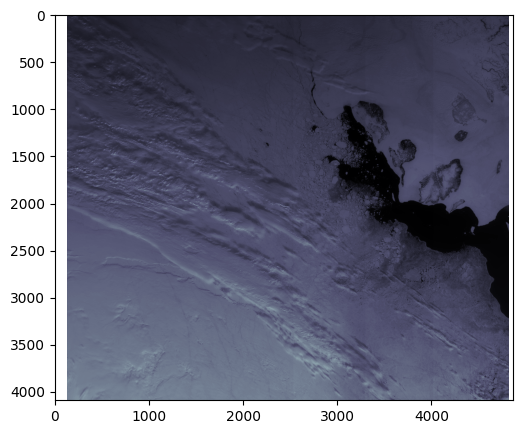

In [9]:
#index = np.where(selects=='S3A_OL_1_EFR____20180607T022426_20180607T022519_20180608T062500_0052_032_089_1080_LN1_O_NT_002')[0][0]
#index = np.where(selects=='S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002')[0][0]
index = np.where(selects=='S3A_OL_1_EFR____20180609T095753_20180609T100053_20180610T150459_0179_032_122_1260_LN1_O_NT_002')[0][0]
fileplot = 'S3A_OL_1_EFR____20180610T061544_20180610T061844_20180611T110424_0179_032_134_1620_LN1_O_NT_002'
lat = Dataset(pathOLCI+selects[index]+'.SEN3/geo_coordinates.nc')['latitude'][:]
lon = Dataset(pathOLCI+selects[index]+'.SEN3/geo_coordinates.nc')['longitude'][:]
data = np.asarray(Dataset(pathOLCI+selects[index]+'.SEN3/Oa01_radiance.nc')['Oa01_radiance'][:])
#data = np.asarray(Dataset(pathS2+fileplot+'.SEN3/Oa01_radiance.nc')['Oa01_radiance'][:])
data[data==65535]=np.nan
print(np.median(lat),np.median(lon))
plt.figure(figsize=(15,5))
plt.imshow(data,cmap='bone')


In [16]:
#%%
#with open('/Volumes/cpdata/SATS/OPTICAL/OLCI/selects/select_files.txt') as f:
#with open('/Volumes/OLCI/selects/select_files.txt') as f:

# Select radiance band:
Radiance=1
R=str("%02d" % Radiance) #defines R as string 0,1 in order to fit it into the file

#if len(selects)[0:1] is =1 make j=0
#for file in selects
#selects=glob.glob('/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/selects/*.png') --> selecting a file
#index = np.where(selects=='S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002')[0][0]
#index = np.where(selects=='S3A_OL_1_EFR____20180607T022426_20180607T022519_20180608T062500_0052_032_089_1080_LN1_O_NT_002')[0][0]
index = np.where(selects=='S3A_OL_1_EFR____20180609T095753_20180609T100053_20180610T150459_0179_032_122_1260_LN1_O_NT_002')[0][0]
print(index)
for file in selects[index:index+1]:
    j = index
    OLCI_file=file
    #OLCI_file = 'S3A_OL_1_EFR____20180610T061544_20180610T061844_20180611T110424_0179_032_134_1620_LN1_O_NT_002'
    OLCI_file = 'S3A_OL_1_EFR____20180630T174056_20180630T174356_20180701T224026_0180_033_041_1440_LN1_O_NT_002'
    print(OLCI_file)
#     tif_file=OLCI_file+'/true_color.tif'

    geo_coords=Dataset(pathOLCI + OLCI_file + '.SEN3/geo_coordinates.nc')  #+'_002.SEN3'+'/'+ OLCI_file+'_002.SEN3'
    #geo_coords=Dataset(pathS2 + OLCI_file + '.SEN3/geo_coordinates.nc')
    OLCI_lat=geo_coords['latitude'][:]
    OLCI_lon=geo_coords['longitude'][:]
    print('yep')

#load radiances --> for only one radiance in this case
#dataset is a command that allows you to read nc files
    OLCI_data=Dataset(pathOLCI +OLCI_file+'.SEN3'+'/Oa'+R+'_radiance.nc')
    #OLCI_data=Dataset(pathS2 +OLCI_file+'.SEN3'+'/Oa'+R+'_radiance.nc')
#turn it into an array
    OLCI_z=np.asarray(OLCI_data['Oa'+R+'_radiance'])
#end up with an array of all the data from OLCI
    OLCI_z[OLCI_z==65535]=np.nan #did a bit of masking here

    #Need to find corresponsing SAR file (timecodes are different):

    SAR_file=matching_SAR_list[j]
    #SAR_file = 'S3A_SR_2_LAN_SI_20180610T060405_20180610T061955_20230507T172357_0949_032_134______LN3_R_NT_005.SEN3'
    SAR_file = 'S3A_SR_2_LAN_SI_20180630T173610_20180630T174819_20230507T235024_0729_033_041______LN3_R_NT_005.SEN3'
    print('overlapping SAR file is',SAR_file)
#    SAR_data=Dataset('/Volumes/cpdata/SATS/RA/S3A/L1B/GPOD_PROCESSED/201803/'+SAR_file)
#    SAR_data=Dataset('/Volumes/GPOD_PROCESSED/201803/'+SAR_file)
    SAR_data=Dataset(pathSAR +'SAR_data/'+SAR_file+'/enhanced_measurement.nc')

#    SAR_data=Dataset(dir_path+'/Volumes/GPOD_PROCESSED/201803/'+SAR_file)
#corresponding array with all the data from the altimeter
#read all the quanties we are intrested in
    SAR_lat, SAR_lon, waves, sig_0, RIP= unpack_gpod('lat_20_ku'), unpack_gpod('lon_20_ku'), unpack_gpod('waveform_20_ku'),unpack_gpod('sig0_water_20_ku'),unpack_gpod('rip_20_ku')#unpack_gpod('Sigma0_20Hz')
    SAR_index=np.arange(np.size(SAR_lat))
    start = find_sections(SAR_file,OLCI_file,len(waves))[0]
    SAR_flags = Dataset(pathSAR + 'SAR_data/'+SAR_file+'/enhanced_measurement.nc')['surf_type_class_20_ku'][:]
    full_shape = waves.shape[0]
    #SAR_lat, SAR_lon, waves, sig_0, RIP = SAR_lat[where_sea], SAR_lon[where_sea], waves[where_sea], sig_0[where_sea], RIP[where_sea]

    find=np.where(SAR_lat >= -99999)#60
    SAR_lat=SAR_lat[find]
    SAR_lon=SAR_lon[find]
    SAR_index=SAR_index[find]
    waves=waves[find]
    sig_0=sig_0[find]
    RIP=RIP[find]

    PP=peakiness(waves)
    SSD=calculate_SSD(RIP)

#    SL_flagfile=('/Volumes/GPOD_PROCESSED/201803/lead_floe_flags/'+SAR_file[0:-7]+'_00_lead.nc')
    #SL_flagfile=(SAR_file[0:-7]+'_00_lead.nc')
    #print('SL file')
    #print(SL_lead_file)
    #flag_data=Dataset(SL_flagfile)
    #flag=flag_data['lead_abun_1'][:]

    #flag=flag[find]
    #print(flag.shape)



    SAR_lon_orig, SAR_lat_orig, SAR_index_orig, PP_orig, sig_0_orig, SSD_orig, flag_orig = np.copy(SAR_lon), np.copy(SAR_lat), np.copy(SAR_index), np.copy(PP), np.copy(sig_0), np.copy(SSD), 5#np.copy(flag)

    print("SAR shape", SAR_lon.shape,"OLCI shape",OLCI_lon.shape)
    OLCI_lon=OLCI_lon.ravel()
    OLCI_lat=OLCI_lat.ravel()
    OLCI_z_orig=OLCI_z.ravel()

    # Convert lons to 360 degree format
    SAR_lon[SAR_lon<0]=360+SAR_lon[SAR_lon<0]
    OLCI_lon[OLCI_lon<0]=360+OLCI_lon[OLCI_lon<0]
    sects=int(len(SAR_lat)/300)

    print('plotting',sects,'sections')

    # Here you are plotting the 18th segment of 300 footprints
    #only 21-26 seem to work for now
    nstart,nend = find_sections(SAR_file,OLCI_file,full_shape)
    print(f"sections {nstart}-{nend}")
    for n in range(18,21):#nstart,nend):


        # Define the index
        k,l=n*300,(n*300)+300

        # Take the data for this segment [k:1] of 200 values between n*200 and (n*200)+200

        SAR_lon, SAR_lat, SAR_index, PP, sig_0, SSD, flag=SAR_lon_orig[k:l], SAR_lat_orig[k:l], SAR_index_orig[k:l], PP_orig[k:l], sig_0_orig[k:l], SSD_orig[k:l], 5#flag_orig[k:l]
        #where_sea = np.where((SAR_flags[k:l]<3)&(SAR_flags[k:l]>0))[0]
        sig_0_np = np.array(sig_0)  # Replace [...] with your data
        RIP_np = np.array(RIP)
        PP_np = np.array(PP)
        SSD_np = np.array(SSD)
        # Here you get K-Means/Gaussian Mixture classification
        data = np.column_stack((sig_0_np,PP_np, SSD_np))
        # Standardize the data
        scaler = StandardScaler()
        data_normalized = scaler.fit_transform(data)
########################################################################
#Trying autoencoder
########################################################################
        '''
        scaler = MinMaxScaler()
        data_normalized = scaler.fit_transform(data)

        # Build an autoencoder
        input_dim = data.shape[1]
        encoding_dim = 16  # Adjust this based on the desired dimensionality of the encoded representation

        autoencoder = Sequential()
        autoencoder.add(Dense(encoding_dim, activation='relu', input_shape=(input_dim,),activity_regularizer=regularizers.l1(1e-5)))
        autoencoder.add(Dense(input_dim, activation='sigmoid'))

        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        # Train the autoencoder
        autoencoder.fit(data_normalized, data_normalized, epochs=50, batch_size=32, shuffle=True)

        # Extract the encoded representations
        encoded_data = autoencoder.predict(data_normalized)

        # Apply K-means clustering on the encoded representations
        n_clusters = 4
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels = kmeans.fit_predict(encoded_data)
        #gmm = GaussianMixture(n_components=2, random_state=0)
        #gmm.fit(data_normalized)
        #labels_gmm = gmm.predict(encoded_data)
        '''
########################################################################


        #Apply K-means clustering
        #kmeans = KMeans(n_clusters=5, random_state=0)
        #clusters_kmeans = kmeans.fit_predict(data_normalized)

        #gmm = GaussianMixture(n_components=5, random_state=0)
        #gmm.fit(data_normalized)

        # Get the cluster assignments
        #clusters_gmm = gmm.predict(data_normalized)

        '''
        #hierarchical clustering
        linked = linkage(data_normalized, method='ward')
        num_clusters = 2
        clusters_hi = fcluster(linked, num_clusters, criterion='maxclust') - 1
        '''
        #manual_labels = np.loadtxt(pathSAR+'Model_predictions/5100_5400_S3A_SR_2_LAN_SI_20180607T022007_20180607T023428_20230507T191926_0861_032_089______LN3_R_NT_005.SEN3.txt')
        #manual_labels = np.loadtxt(pathSAR+'Labels/S3A_SR_2_LAN_SI_20180607T022007_20180607T023428_20230507T191926_0861_032_089______LN3_R_NT_005.SEN3_4800_5099.txt')

        label_indices = np.where((SAR_flags<3)&(SAR_flags>0))[0]
        #where_sea_no_outliers = label_indices[no_outliers]
        #flag = clusters_kmeans
        flag = manual_labels[np.where((where_sea_no_outliers>k-1) & (where_sea_no_outliers<l))[0]] #insert flags.
        label_method = 'gmm'

        final_flags = []

        for b in range(int(np.max(flag)+1)):

          spec_SL = np.where(flag==b)[0]
          spec_SL = np.asarray(spec_SL)
          spec_SL = spec_SL.flatten()
          final_flags.append(spec_SL)
        print("flags shape:",len(final_flags))

        '''
        diff_SL = np.where(flag==0)[0]
        diff_SL = np.asarray(diff_SL)
        diff_SL = diff_SL.flatten()

        oth_SL = np.where(flag==2)[0]
        oth_SL = np.asarray(oth_SL)
        oth_SL = oth_SL.flatten()

        mhm_SL = np.where(flag==3)[0]
        mhm_SL = np.asarray(mhm_SL)
        mhm_SL = mhm_SL.flatten()
        '''
        # Find central coordinates of SAR track:
        SAR_central_lat=np.min(SAR_lat)+0.5*(np.max(SAR_lat)-np.min(SAR_lat))
        SAR_central_lon=np.min(SAR_lon)+0.5*(np.max(SAR_lon)-np.min(SAR_lon))

        OLCI_central_lat = np.min(OLCI_lat)+0.5*(np.max(OLCI_lat)-np.min(OLCI_lat))
        OLCI_central_lon = np.min(OLCI_lon)+0.5*(np.max(OLCI_lon)-np.min(OLCI_lon))

        print('lon/lat of SAR track image centre',SAR_central_lon,SAR_central_lat)
        print('lon/lat of OLCI track image centre',OLCI_central_lon,OLCI_central_lat)
        print("min lon of SAR:", np.min(SAR_lon), "shape:", SAR_lon.shape)

        # width that contributes to the footprint- effect up until the return is negligible
        w=100000
        m = Basemap(resolution='l',projection='laea',ellps='WGS84', lat_ts=0,  lat_0= SAR_central_lat, lon_0=SAR_central_lon, width=w,height=w)

        # Convert lon lat to map coordinates:
        OLCI_x,OLCI_y=m(OLCI_lon,OLCI_lat)
        SAR_x,SAR_y=m(SAR_lon,SAR_lat)
        print("OLCI shape:",OLCI_x.shape)
        print("min and max:",np.median(OLCI_x),np.max(OLCI_x))
        print("SAR_x:",SAR_x[int(len(SAR_x)/2)])

        # Remove OLCI points outside map projection:
        OLCI_X=OLCI_x[np.where((OLCI_x <= w) & (OLCI_x >= 0) & (OLCI_y <= w) & (OLCI_y >= 0))]
        OLCI_Y=OLCI_y[np.where((OLCI_x <= w) & (OLCI_x >= 0) & (OLCI_y <= w) & (OLCI_y >= 0))]
        OLCI_Z=OLCI_z_orig[np.where((OLCI_x <= w) & (OLCI_x >= 0) & (OLCI_y <= w) & (OLCI_y >= 0))]

        OLCI_x=OLCI_X
        OLCI_y=OLCI_Y
        OLCI_z=OLCI_Z

        # np.size() counts the number of elements along a given axis
        # If we have OLCI positions in our map projection
        print("OLCI within map:",np.shape(OLCI_x))
        if np.size(OLCI_x) > 0:

            # Do a KDtree to find all OLCI points within a 2km diameter (1km radius) of each SAR footprint.
            points=(OLCI_x,OLCI_y)
            points=np.transpose(points)
            point_tree = spatial.cKDTree(points)

            nearby_x=[]
            nearby_y=[]
            nearby_z=[]

            # number of SAR points is given by the number of lon values
            for i in range(np.size(SAR_lon)):

                coordinate=[SAR_x[i],SAR_y[i]]

                match_indices=point_tree.query_ball_point(coordinate, 1000) #search radius in metres: 1000

                nearby_x.extend(OLCI_x[match_indices])
                nearby_y.extend(OLCI_y[match_indices])
            print("match_size",np.size(match_indices))
            if np.size(match_indices) > 0:

                # plt.figure(figsize=(30,30),dpi=400)
                # Plot OLCI data:
                # m.scatter(OLCI_x,OLCI_y,c=OLCI_z,s=90,marker='o',cmap='bone')

                # Remove neighbour duplicates:
                b=np.transpose(np.vstack([nearby_x,nearby_y]))
                unique=np.vstack(list({tuple(e) for e in b}))


                # # Plot neighbours in transparent white:
                # m.scatter(unique[:,0],unique[:,1],s=80,c='white',alpha=0.3)

                # m.drawcoastlines(linewidth=0.2,color='red',linestyle='-.')

                # # Plot all footprints in grey:
                # m.scatter(SAR_x,SAR_y,s=105,marker="o",c='grey',zorder=2)
                # # Plot floes in red:
                # m.scatter(SAR_x[diff],SAR_y[diff],s=105,marker="o",c='red',zorder=2)
                # # Plot leads in blue:
                # m.scatter(SAR_x[spec],SAR_y[spec],s=105,marker="o",c='mediumblue',zorder=2)

                # # Plot the index of each footprint next to the footprint:
                # p=-1
                # for ind in range(200):
                #     p=p+1
                #     plt.text(SAR_x[ind]+30,SAR_y[ind]-10,str(SAR_index[ind]),fontsize=1.8,color='white')

                # plt.title('SAR file '+SAR_file+' section '+str(n)+' of '+str(sects)+'\n over OLCI file '+file,fontsize=15)
                # plt.tight_layout()
                # #plt.savefig('/Volumes/OLCI/selects/SAR_file_'+SAR_file+'_over_OLCI_sect'+str(n)+'_ppthresh_leads_floes.png',dpi=400)
                # plt.show()
                # plt.clf()

                plt.figure(figsize=(30,30),dpi=400)
                # Plot OLCI data:
                m.scatter(OLCI_x,OLCI_y,c=OLCI_z,s=60,marker='o',cmap='bone')

                # Plot neighbours in transparent white:
                #m.scatter(unique[:,0],unique[:,1],s=80,c='white',alpha=0.3)

                m.drawcoastlines(linewidth=0.2,color='red',linestyle='-.')

                # Plot all footprints in grey:
                #m.scatter(SAR_x,SAR_y,s=105,marker="o",c='grey',zorder=2)
                # Plot floes in red:
                points = where_sea_no_outliers[np.where((where_sea_no_outliers>k-1) & (where_sea_no_outliers<l))[0]]-k
                SAR_x, SAR_y = SAR_x[points],SAR_y[points]
                print("shapes:",SAR_x.shape,flag.shape)
                for b in range(int(np.max(flag)+1)):
                  m.scatter(SAR_x[final_flags[b]],SAR_y[final_flags[b]],s=30,marker="o",zorder=2)
                '''
                m.scatter(SAR_x[diff_SL],SAR_y[diff_SL],s=30,marker="o",c='red',zorder=2)
                # Plot leads in blue:
                m.scatter(SAR_x[spec_SL],SAR_y[spec_SL],s=30,marker="o",c='mediumblue',zorder=2)
                #Plot other in yellow:
                m.scatter(SAR_x[oth_SL],SAR_y[oth_SL],s=30,marker="o",c='yellow',zorder=2)
                m.scatter(SAR_x[mhm_SL],SAR_y[mhm_SL],s=30,marker="o",c='pink',zorder=2)
                '''
                # Plot the index of each footprint next to the footprint:
                SAR_index = SAR_index[points]
                p=-1
                for ind in range(len(SAR_x)):
                    p=p+1
                    plt.text(SAR_x[ind]+30,SAR_y[ind]-10,str(SAR_index[ind]),fontsize=1.8,color='white')

                plt.title('SAR file '+SAR_file+' section '+str(n)+' of '+str(sects)+'\n over OLCI file '+file,fontsize=15)
                plt.tight_layout()
                #plt.savefig(f'/content/drive/MyDrive/Colab_Notebooks/Project/Tracks/test_new_{n}.png',dpi=400)
                #plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Project/Tracks/'+'5CLASS_SAR_file_'+SAR_file+'_over_OLCI_sect'+str(n)+f'_SLee_leads_floes_{label_method}.png',dpi=400)
                #plt.savefig(pathSAR+'Model_plots/40June_on_'+SAR_file+f'section_{n}_of_{sects}.png',dpi=400)
                plt.savefig(pathSAR+f'Kmedoid_plots/40July_{SAR_file[16:31]}_Section_{n}.png',dpi=400)
                #plt.savefig(pathSAR+'Model_plots/'+'kmeans2_compare.png',dpi=400)
                print("yes")
                #plt.clf()


70
S3A_OL_1_EFR____20180630T174056_20180630T174356_20180701T224026_0180_033_041_1440_LN1_O_NT_002
yep
overlapping SAR file is S3A_SR_2_LAN_SI_20180630T173610_20180630T174819_20230507T235024_0729_033_041______LN3_R_NT_005.SEN3
Running peakiness function...


<ipython-input-4-da0083fa8885>:48: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


SAR shape (11106,) OLCI shape (4090, 4865)
plotting 37 sections
sections 14-23


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
print(final_flags)

[array([    7,   224,   339, ..., 11097, 11101, 11102]), array([    0,     1,     2, ..., 11103, 11104, 11105])]


$\nu$

In [ ]:
 SAR_flags = Dataset(pathSAR + 'SAR_data/'+SAR_file+'/enhanced_measurement.nc')['surf_type_class_20_ku']
 print(SAR_flags)

['S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002.SEN3', 'S3A_OL_1_EFR____20180609T095753_20180609T100053_20180610T150459_0179_032_122_1260_LN1_O_NT_002.SEN3', 'S3A_OL_1_EFR____20180607T022426_20180607T022519_20180608T062500_0052_032_089_1080_LN1_O_NT_002.SEN3']


In [ ]:
#manual_labels = np.loadtxt(pathSAR+'Labels/S3A_SR_2_LAN_SI_20180607T022007_20180607T023428_20230507T191926_0861_032_089______LN3_R_NT_005.SEN3_4800_5099.txt')
#manual_labels = np.append(manual_labels,0)
import numpy as np
#manual_labels = np.load(pathSAR+'Unsup_labels/kmean_labels_param_normal_160-180.npy')
manual_labels = np.load(pathSAR+'Model_predictions/June_model_predictions_0609.npy')[:,0]
#manual_labels = np.load(pathSAR+'Unsup_labels/labels_kmedoids2Sam.mat')
print(manual_labels.shape)
#manual_labels = manual_labels[144183:155666]
print(manual_labels.shape)
print(len(manual_labels[manual_labels==1]))
#print(manual_labels[5180:5190])
#9 is lead

(15184,)
(15184,)
7814


In [14]:
import h5py

# Open the .mat file
mat_file = h5py.File(pathSAR+'Unsup_labels/kmedoids_clusters_monthly4Sam.mat', 'r')
#SAR_file = 'S3A_SR_2_LAN_SI_20180607T022007_20180607T023428_20230507T191926_0861_032_089______LN3_R_NT_005.SEN3'
SAR_file = 'S3A_SR_2_LAN_SI_20180630T173610_20180630T174819_20230507T235024_0729_033_041______LN3_R_NT_005.SEN3'
flags=Dataset(pathSAR +'SAR_data/'+SAR_file+'/enhanced_measurement.nc')['surf_type_class_20_ku'][:]
print(flags.shape)
print(flags[np.where((flags>0)&(flags<3))].shape)

print(mat_file)
variable_names = list(mat_file.keys())
print(variable_names)
data = mat_file['July_data_kmedoids']
print(list(data.keys()))
data = mat_file['July_data_kmedoids']['c40']
manual_labels_full = data[0]
print("full_shape:",manual_labels_full.shape)
#print(len(manual_labels[manual_labels==7]),len(manual_labels[manual_labels==17]),len(manual_labels))
#(843315, 256)
#(854799, 256)
#808724:819949 June 7th 02
manual_labels = manual_labels_full[369662:371074]
#print(manual_labels[2],"=17,7?")
print("shape:",manual_labels.shape)
no_outliers = np.load(pathSAR+'Unsup_labels/0630_no_outliers_indices.npy')
print(no_outliers.shape,no_outliers)
label_indices = np.where((flags<3)&(flags>0))[0]
where_sea_no_outliers = label_indices[no_outliers]
#manual_lab_ind = np.where(where_sea_no_outliers==5400)[0][0]
#print(manual_lab_ind)
#print("lead at ",manual_labels[manual_lab_ind:manual_lab_ind+10])
#print("lead at",manual_labels[manual_lab_ind])
#classes = manual_labels[manual_lab_ind]
#print("class size:",manual_labels_full[manual_labels_full==classes].shape)
#leads are 12, 28,18,8,34,33?
#non leads are 30,16,4,10,30,20,23?,22,13

(11106,)
(1412,)
<HDF5 file "kmedoids_clusters_monthly4Sam.mat" (mode r)>
['#refs#', 'August_data_kmedoids', 'July_data_kmedoids', 'June_data_kmedoids', 'October_data_kmedoids', 'September_data_kmedoids']
['c15', 'c40']
full_shape: (3118660,)
shape: (1412,)
(1350,) [   0    1    2 ... 1407 1408 1411]


In [ ]:
print(manual_labels_full.shape)
np.save(pathSAR+'40June_labels_full.npy',manual_labels_full)

(3418968,)


In [ ]:
label_indices = np.where(SAR_flags<3)[0]
print(np.where(label_indices==5094))
print(print(manual_labels[np.where(label_indices==5508)[0]],"=7?"))
print(manual_labels[2980:2990])
#flag = manual_labels[np.where((label_indices>k-1) & (label_indices<l))[0]]
#leads are 7,17?,25,14?

(array([2920]),)
[25.] =7?
None
[11. 23. 23. 23. 19. 23.  2. 10.  7. 12.]


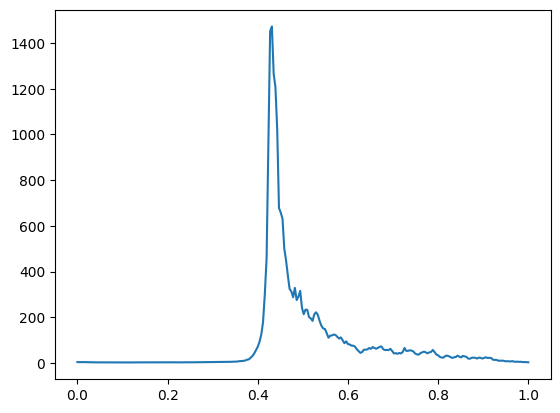

<class 'netCDF4._netCDF4.Variable'>
uint32 waveform_20_ku(time_20_ku, wf_sample_ind)
    _FillValue: 4294967295
    long_name: Waveform samples (I2+Q2) : 20 Hz Ku band
    scale_factor: 0.001
    add_offset: 0.0
    units: count
    comment: LRM mode Ku and C bands: the echo is corrected for the GPRW effect, SAR mode C band : the echo is the so-called averaged echo corrected for the GPRW effect, SAR mode Ku band : the echo is corrected for Doppler range effect, phase/power burst calibration and GPWR effect
unlimited dimensions: 
current shape = (16671, 256)
filling on


Text(0.5, 0, 'Waveform Range Bin')

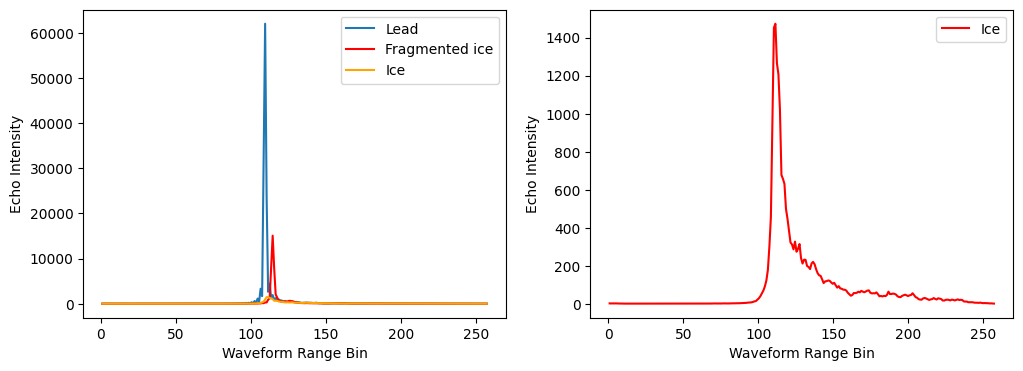

In [ ]:
test = Dataset(pathSAR+'SAR_data/S3A_SR_2_LAN_SI_20180607T022007_20180607T023428_20230507T191926_0861_032_089______LN3_R_NT_005.SEN3/enhanced_measurement.nc')['waveform_20_ku']
print(test)
test = test[:]
x = np.linspace(1,257,256)

plt.figure(figsize=(12,4))
plt.subplot((121))
plt.plot(x,test[5146],label = "Lead")
plt.plot(x,test[5329],'r',label = "Fragmented ice")
plt.plot(x,test[5127],'orange',label = "Ice")
plt.xlabel("Waveform Range Bin")
plt.ylabel("Echo Intensity")
plt.legend(loc="best")
plt.subplot(122)
plt.plot(x,test[5127],'r',label = "Ice")
plt.legend(loc="best")
plt.ylabel("Echo Intensity")
plt.xlabel("Waveform Range Bin")


In [ ]:
print(np.mean(test,axis=1),np.max(test,axis=1)),test.shape
mean = np.mean(test,axis=1)
max = np.max(test,axis = 1)
print(np.where(test==np.max(test)),test.shape,np.max(test))
print(np.mean(max/mean))
print(np.std(max/mean))
print((np.max(test[5433])/np.mean(test[5433])-np.mean(max/mean))/np.std(max/mean))

[ 122.73587891   95.31204297  106.70405078 ... 1581.66704687 8178.89873438
 9241.22668359] [   8569.16     3916.77     6021.489 ...  168863.565  998592.427
 1092102.087]
(array([16656]), array([6])) (16671, 256) 1226696.781
32.381007339509786
28.680870551131658
2.3073026869409543
